Authors: Jakidxav, Dennis Hartmann

Date: 04.03.2019

This Notebook demonstrates how we can compute trends and uncertainties on temperature data to see how sensitive those trends are to starting and ending dates. To do so, we can look at GISTEMP v3 data, which is global-mean, monthly-mean temperature estimates based on land-surface air temperature anomalies.

If you want to download the data for yourself, it was retrieved from [here](https://data.giss.nasa.gov/gistemp/).

### Data Cleaning

In [1]:
#data imports
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#provide file path, in this case just the name of the file
#filename = 'GISSTEMP_SEASONS_2019.txt'
filename = 'GLB.Ts.csv'

# name colors here
deeppink= '#FF1493'

#set significance level for analysis
sig_level = 0.975
sig_level_string = '95%'

In [3]:
#read in data to dataframe, skip header row
df = pd.read_csv(filename, header=1)

df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.81,-0.40,-.47,-.66,-.36,-.48,-.47,.08,-.49,-.66,-.50,-.52,-.48,***,***,-.49,-.29,-.55
1,1881,-0.79,-0.61,-.36,-.25,-.02,-1.10,-.52,-.23,-.32,-.46,-.55,-.13,-.45,-.48,-.64,-.21,-.62,-.44
2,1882,0.13,-0.10,-.07,-.57,-.36,-1.01,-.70,-.10,-.06,-.29,-.38,-.66,-.35,-.30,-.04,-.33,-.60,-.24
3,1883,-0.66,-0.93,-.44,-.29,-.33,.46,-.01,-.15,-.44,-.55,-.68,-.39,-.37,-.39,-.75,-.35,.10,-.56
4,1884,-0.62,-0.35,-.40,-.94,-1.20,-.83,-.86,.14,-.38,-.78,-.83,-1.01,-.67,-.62,-.45,-.85,-.52,-.66


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 19 columns):
Year    140 non-null int64
Jan     140 non-null float64
Feb     140 non-null float64
Mar     140 non-null object
Apr     140 non-null object
May     140 non-null object
Jun     140 non-null object
Jul     140 non-null object
Aug     140 non-null object
Sep     140 non-null object
Oct     140 non-null object
Nov     140 non-null object
Dec     140 non-null object
J-D     140 non-null object
D-N     140 non-null object
DJF     140 non-null object
MAM     140 non-null object
JJA     140 non-null object
SON     140 non-null object
dtypes: float64(2), int64(1), object(16)
memory usage: 20.9+ KB


There are a couple of pre-processing steps that we need to do before we can fully work with this data set. First, you'll notice from the `df.info()` printout that most of our columns are of the type `object`. This is strange since all of our data is numerical. As is turns out, missing values are encoded as `***`, which are of `str` type. Thus, we will need to convert all of our numerical columns (other than the Year column) to type `float` before we start our analysis. Pandas makes this easy with the `pd.to_numeric()` command.

There aren't many missing values in our data set, but they still need to be dealt with. Most of them show up in 2019, as they are placeholders for data that hasn't occured yet. To make our analysis easier, I am going to go ahead and drop that row from the data set. Then we can replace all of our remaining missing values with NaN's. This will allow us to calculate the mean of each column (in Pandas, NaN's are ignored by default in this calculation), and then replace each NaN with that value.

In [5]:
#clean data: replace missing values and drop last incomplete row
def clean(dataframe):
    #replace missing values with NaNs
    dataframe = dataframe.replace('***', np.nan)

    #drop last row since it does not contain a full year's worth of data
    dataframe = dataframe.drop(dataframe.index[-1], axis=0)

    #convert columns from type object to type 'numeric' for calculations
    for col in dataframe:
            dataframe[col] = pd.to_numeric(dataframe[col])

    #replace NaN values with column averages
    dn_avg = np.round(dataframe.loc[:, 'D-N'].mean(), 2)
    djf_avg = np.round(dataframe.loc[:, 'DJF'].mean(), 2)

    dataframe.loc[0, 'D-N'] = dn_avg
    dataframe.loc[0, 'DJF'] = djf_avg

    return dataframe

In [6]:
#clean data
df = clean(df)

Now our data is processed and cleaned, we can begin our analysis here. But first, let's take a look at our dataset. We have a column that holds the years 1800-2018 inclusive. We also have columns for every month of the year, which hold a temperature in degrees Celsius during the year. </br>

Additionally, we have two different annual average columns (although for the purposes of this Notebook I recommend using 'J-D'), and seasonal average columns.

In [7]:
df.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.81,-0.40,-0.47,-0.66,-0.36,-0.48,-0.47,0.08,-0.49,-0.66,-0.50,-0.52,-0.48,0.03,0.02,-0.49,-0.29,-0.55
1,1881,-0.79,-0.61,-0.36,-0.25,-0.02,-1.10,-0.52,-0.23,-0.32,-0.46,-0.55,-0.13,-0.45,-0.48,-0.64,-0.21,-0.62,-0.44
2,1882,0.13,-0.10,-0.07,-0.57,-0.36,-1.01,-0.70,-0.10,-0.06,-0.29,-0.38,-0.66,-0.35,-0.30,-0.04,-0.33,-0.60,-0.24
3,1883,-0.66,-0.93,-0.44,-0.29,-0.33,0.46,-0.01,-0.15,-0.44,-0.55,-0.68,-0.39,-0.37,-0.39,-0.75,-0.35,0.10,-0.56
4,1884,-0.62,-0.35,-0.40,-0.94,-1.20,-0.83,-0.86,0.14,-0.38,-0.78,-0.83,-1.01,-0.67,-0.62,-0.45,-0.85,-0.52,-0.66


### Data Analysis and Plotting

We are going to calculate the trend for different starting and ending times of this data. This is a linear regression of the form $y = mx + b$.

Below is an example of what this Notebook is trying to demonstrate. You can see that by using different starting or ending dates, the slope of the trend changes. Not only that, but the sensitivity of our trend line changes. The sensitivity corresponds to confidence limits that we can place on the slope and intercept of our regression fit. In our case, we have done this by running a t-test at the 95% confidence level.

DOF stands for "degrees of freedom". We need to calculate this for our trend line because not every data point (month, year) in our sample is independent. If we did not do this calculation, we would be overestimating the amount of years we should use in our significance test. If $N$ is the number of years we have in a given sample, we can estimate the degrees of freedom as $N * \frac{1 - autocorrelation}{1 + autocorrelation}$.

<img src='example_trends.png'>

### Helper Methods

The next part is the where we can start the actual analysis. Below is where I have made a few helper methods that calculate autocorrelation, degrees of freedom, and the time series residuals, do significance testing, and plot our results. These methods can also be found in the helper file `process_gssi_global_temp.py` in this repository.

We first need to find the autocorrelation of a given column's time series to itself for a time lag of one month, then the degrees of freedom. With that information, we can run a t-test at the 95% confidence interval and place confidence limits on our trend lines.

Part of this code has been adapted from programs written by Dennis Hartmann: auto.m and lintg.m

In [13]:
#This function calculates the autocorrelation function for our data set for
#a 1-month time lag.
def auto(data):
    data1 = data[:-1]
    data1 = data1 - np.mean(data1)

    data2 = data[1:]
    data2 = data2 - np.mean(data2)

    top = np.sum(np.multiply(data1, data2))
    bottom = np.sqrt(np.multiply(np.sum(data1**2), np.sum(data2**2)))
    a = top / bottom
    
    if a <= 0:
        a = 0

    return a

In [14]:
#This method takes in a dataframe and a column name for the GSSI Global Temperature data.
#It calculates the covariance, residuals, and autocorrelation for those residuals, and returns
#the length of the input data, the variance, the parameters a0 and a1, the residual, and its autocorrelation for a 1 time-step lag.
def calculate_res_autocorr(dataframe, column_name):
    temp = dataframe[column_name]
    temp_mean = np.mean(temp)
    temp_anom = temp - temp_mean
    time = dataframe['Year'].values
    td = time - np.mean(time)
    n = len(time)

    #covariance
    ttp = np.matmul(np.matrix(td), np.matrix(temp_anom).T) / n
    vart = np.matmul(td.T, td) / n
    a1 = ttp / vart
    a0 = temp_mean - (a1 * np.mean(time))

    #compute residuals
    temp_res = temp.values - (a0 + (a1 * time))

    #convert from matrix back to numpy array
    temp_res = np.array(temp_res)[0]
    residual = np.mean(temp_res)

    #compute autocorrelation of residuals
    autocorr = auto(temp_res)

    return n, vart, a0, a1, temp_res, residual, autocorr

In [15]:
#This method computs the sensitivity of a given trend. To do so, it calculates the degrees
#of freedom for a given autocorrelation, and confidence limits using residuals. Then a t-test
#is performed for a given level of significance. Currently, only 95% significance is implemented.
def calculate_significance(n, a0, a1, vart, autocorr, temp_res):
    # compute confidence limits on slope
    #first compute estimated degrees of freedom from red noise model of residuals.
    dof = n * (1 - autocorr) / ( 1 + autocorr)

    #Compute the error variance adjusted for DOF
    se2 = np.matmul(temp_res.T, temp_res) / (dof - 2)
    sigb = se2 / (vart * n)

    #compute % limits on b
    critical_t = stats.t.ppf(q=0.975, df=dof - 2)
    sb2 = se2 / (n * vart)
    sb = np.sqrt(sb2)

    low_t = a1 - sb * critical_t
    high_t = a1 + sb * critical_t
    delta_a = sb * critical_t * 10
    a1_t = a1 * 10

    return dof, sb, critical_t, low_t, high_t, delta_a, a1_t

In [16]:
#matplotlib plotting method for plotting temperature anomaly data along with linear fit
#provided by a start and end year
def plot(start, end, dataframe, column, c, sig_level, save_fig):
    #check for correct year input
    minyr = dataframe.Year.min()
    maxyr = dataframe.Year.max()
    
    start = int(start)
    end = int(end)
    
    #make sure input is in between correct years
    if np.logical_or(start<minyr, end>maxyr):
        print('Please enter integer years between 1880 and 2018!')
        return
    

    #create indexer array
    tidx = np.logical_and(dataframe.Year >= start, dataframe.Year <= end)
    
    #subset for different times
    trend = dataframe[tidx]
    
    #calculate temperature anomaly here
    anomaly = dataframe[column] - dataframe[column].mean()

    #linear regressions
    x = trend.Year
    y = trend[column]
    m, b = np.polyfit(x, y, 1)

    #calculate residuals and autocorrelation
    n, vart, a0, a1, temp_res, residual, autocorr = calculate_res_autocorr(trend, column)

    #significance testing
    dof, sb, critical_t, low_t, high_t, delta_a, a1_t = calculate_significance(n, a0, a1, vart, autocorr, temp_res)
    a1_t = float(a1_t)

    plt.figure(figsize=(12,8))
    label = '{}-{} trends, {} significance, {:.3f} $\pm$ {:.3f}, DOF = {:.2f}'.format(start, end, sig_level, a1_t, delta_a, dof)

    plt.plot(dataframe.Year, anomaly, color='k', linewidth=2, label='Anomaly Data, {}'.format(column))
    plt.plot(x, m*x+b, color=c, linewidth=2, label=label) 

        #label axes
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('T Anomaly (C)', fontsize=14)

    #add legend
    plt.legend(fontsize='large')

    #creat figure name in case user decides to save
    figname = 'trend_{}_{}-{}_sig{}.png'.format(column, start, end, sig_level)

    if save_fig==True:
        plt.savefig(figname, format='png', bbox_inches='tight')

    plt.show()

#### Now it is your turn! Change the start and end years below and re-run the plotting method to see how the trend line changes. You should also feel free to change the column in question. You can save the plot by  changing `save_figure` to `True`.

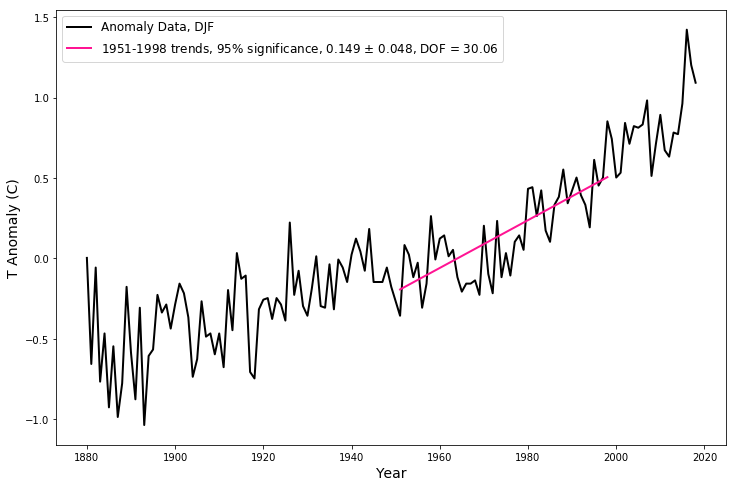

In [17]:
#Change starting and ending years, as well as the column name here to be plotted here
start_year = 1951
end_year = 1998
column_name = 'DJF'
save_figure = False

plot(start_year, end_year, df, column_name, deeppink, sig_level_string, save_figure)